<a href="https://www.kaggle.com/code/daniyalatta/end-to-end-predicting-the-beats-xgbr-cat-lgb?scriptVersionId=261747771" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e9/sample_submission.csv
/kaggle/input/playground-series-s5e9/train.csv
/kaggle/input/playground-series-s5e9/test.csv


In [2]:
# ------------------ Libraries & Environment ------------------ #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from tqdm import tqdm
import warnings

warnings.simplefilter("ignore")
print("Environment Ready ✅")

Environment Ready ✅


In [3]:
# ------------------ Data Loading ------------------ #
train_path = "/kaggle/input/playground-series-s5e9/train.csv"
test_path  = "/kaggle/input/playground-series-s5e9/test.csv"

train_df = pd.read_csv(train_path, index_col="id")
test_df  = pd.read_csv(test_path, index_col="id")

print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

Train shape: (524164, 10), Test shape: (174722, 9)


In [4]:
train_df.head()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
id,,,,,,,,,,
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


In [5]:
test_df.head()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
id,,,,,,,,,
524164,0.410013,-16.794967,0.023500,0.232910,0.012689,0.271585,0.664321,302901.5498,0.424867
524165,0.463071,-1.357000,0.141818,0.057725,0.257942,0.097624,0.829552,221995.6643,0.846000
524166,0.686569,-3.368928,0.167851,0.287823,0.210915,0.325909,0.304978,357724.0127,0.134067
524167,0.885793,-5.598049,0.118488,0.000005,0.376906,0.134435,0.487740,271790.3989,0.316467
524168,0.637391,-7.068160,0.126099,0.539073,0.068950,0.024300,0.591248,277728.5383,0.481067


In [6]:
train_df.columns.tolist()
test_df.columns.tolist()


['RhythmScore',
 'AudioLoudness',
 'VocalContent',
 'AcousticQuality',
 'InstrumentalScore',
 'LivePerformanceLikelihood',
 'MoodScore',
 'TrackDurationMs',
 'Energy']

In [7]:

# ------------------ Feature Engineering & Imputation ------------------ #
def wrangle(df):
    # Columns to check for 1.07e-06
    columns_to_impute = [
        'RhythmScore', 'AudioLoudness', 'VocalContent', 'AcousticQuality',
        'InstrumentalScore', 'LivePerformanceLikelihood', 'MoodScore',
        'TrackDurationMs', 'Energy'
    ]
    
    # Impute 1.07e-06 with mean for numerical columns
    for col in columns_to_impute:
        if col in df.columns:
            # Replace 1.07e-06 with NaN, then impute with mean
            df[col] = df[col].replace(1.07e-06, np.nan)
            df[col] = df[col].fillna(df[col].mean())
    
    # Log transformation for skewed numerical features
    df['TrackDurationMs_log'] = np.log1p(df['TrackDurationMs'])
    
    # Interaction features
    df['Energy_MoodScore'] = df['Energy'] * df['MoodScore']
    df['Rhythm_Acoustic'] = df['RhythmScore'] * df['AcousticQuality']
    df['Vocal_Instrumental'] = df['VocalContent'] * df['InstrumentalScore']
    
    # Binary features
    df['HighEnergy'] = (df['Energy'] > df['Energy'].median()).astype(int)
    df['HighLiveLikelihood'] = (df['LivePerformanceLikelihood'] > df['LivePerformanceLikelihood'].median()).astype(int)
    
    # Normalize duration to minutes
    df['TrackDurationMin'] = df['TrackDurationMs'] / (1000 * 60)
    
    # New feature: Ratio of VocalContent to InstrumentalScore
    df['Vocal_to_Instrumental'] = df['VocalContent'] / (df['InstrumentalScore'] + 1e-6)  # Avoid division by zero
    
    # Drop original columns to avoid redundancy
    df = df.drop(columns=['TrackDurationMs'], errors='ignore')
    
    return df

train_df = wrangle(train_df)
test_df  = wrangle(test_df)


Target Distribution:


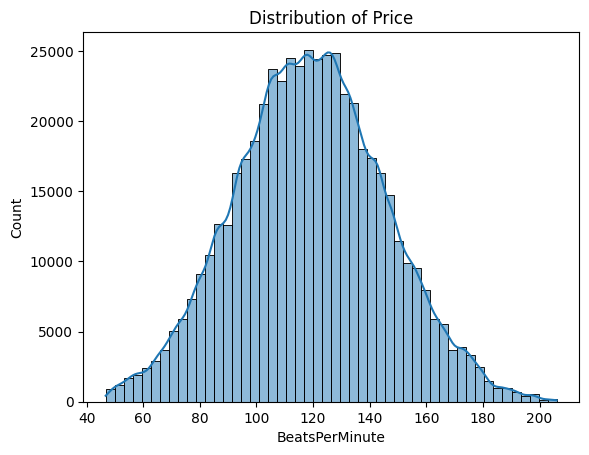

Correlation Matrix:


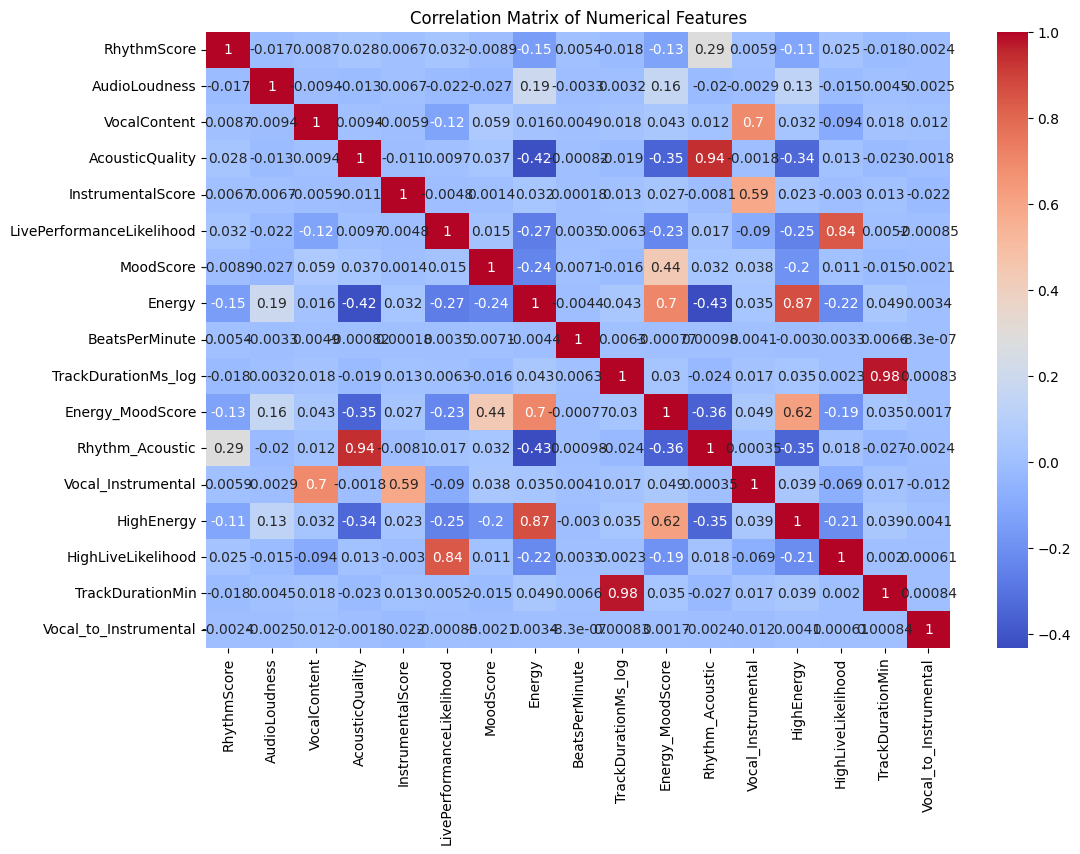

In [8]:
# ------------------ Exploratory Data Analysis ------------------ #
# Target Distribution
print("Target Distribution:")
sns.histplot(train_df['BeatsPerMinute'], bins=50, kde=True)
plt.title("Distribution of Price")
plt.show()

# Correlation Matrix
print("Correlation Matrix:")
corr_matrix = train_df.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Numerical Features")
plt.show()



In [9]:
# ------------------ Train-Test Split ------------------ #
X = train_df.drop(columns=['BeatsPerMinute'])
y = train_df['BeatsPerMinute']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# ------------------ Robust Training & Evaluation ------------------ #
def train_evaluate_submit(models, X_train, X_val, y_train, y_val, test_df):
    results = {}
    
    # Identify categorical and numeric columns
    cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Preprocessor
    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(use_cat_names=True, handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ])
    
    for model in tqdm(models, desc="Training Models"):
        # Full pipeline: preprocessing + model
        pipeline = make_pipeline(
            preprocessor,
            model
        )
        
        # Fit
        pipeline.fit(X_train, y_train)
        
        # Validation predictions
        val_pred = pipeline.predict(X_val)
        
        # Metrics
        rmse_score = mean_squared_error(y_val, val_pred, squared=False)
        print(f"\nModel: {model.__class__.__name__}")
        print(f"RMSE Score: {rmse_score:.4f}")
        
        # Submission predictions
        test_pred = pipeline.predict(test_df)
        sub_df = pd.DataFrame({"BeatsPerMinute": test_pred}, index=test_df.index)
        sub_df.to_csv(f"{model.__class__.__name__}_submission.csv", index=True)
        print(f"Submission file saved: {model.__class__.__name__}_submission.csv")
        
        results[model.__class__.__name__] = rmse_score
    
    return pd.DataFrame.from_dict(results, orient='index', columns=["RMSE"]).sort_values("RMSE")


In [11]:
# Models to train
models = [
    XGBRegressor(random_state=42),
    CatBoostRegressor(random_state=42, verbose=0),
    LGBMRegressor(random_state=42, verbose=-1)
]



In [12]:
# Run training & submission
score_df = train_evaluate_submit(models, X_train, X_val, y_train, y_val, test_df)
print("\nModel Performance Summary:")
print(score_df)

Training Models:   0%|          | 0/3 [00:00<?, ?it/s]


Model: XGBRegressor
RMSE Score: 26.5516


Training Models:  33%|███▎      | 1/3 [00:02<00:05,  2.63s/it]

Submission file saved: XGBRegressor_submission.csv

Model: CatBoostRegressor
RMSE Score: 26.4881


Training Models:  67%|██████▋   | 2/3 [00:31<00:18, 18.13s/it]

Submission file saved: CatBoostRegressor_submission.csv

Model: LGBMRegressor
RMSE Score: 26.4473


Training Models: 100%|██████████| 3/3 [00:34<00:00, 11.44s/it]

Submission file saved: LGBMRegressor_submission.csv

Model Performance Summary:
                        RMSE
LGBMRegressor      26.447298
CatBoostRegressor  26.488062
XGBRegressor       26.551565


In [13]:
# ------------------ Libraries for Model Tuning ------------------ #
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from category_encoders import OneHotEncoder
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import optuna
from tqdm import tqdm
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter("ignore")

# ------------------ Robust Training, Tuning & Evaluation ------------------ #
def train_evaluate_submit(models, X_train, X_val, y_train, y_val, test_df, n_trials=20):
    results = {}
    
    # Identify categorical and numeric columns
    cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Preprocessor
    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(use_cat_names=True, handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ])
    
    def objective(trial, model_type):
        # Define hyperparameter search space based on model type
        if model_type == 'XGBRegressor':
            params = {
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
            }
            model = XGBRegressor(**params, random_state=42)
        elif model_type == 'CatBoostRegressor':
            params = {
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'depth': trial.suggest_int('depth', 4, 10),
                'iterations': trial.suggest_int('iterations', 100, 1000),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10)
            }
            model = CatBoostRegressor(**params, random_state=42, verbose=0)
        elif model_type == 'LGBMRegressor':
            params = {
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'num_leaves': trial.suggest_int('num_leaves', 20, 100),
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0)
            }
            model = LGBMRegressor(**params, random_state=42, verbose=-1)
        
        # Create pipeline
        pipeline = make_pipeline(
            preprocessor,
            model
        )
        
        # Fit model
        pipeline.fit(X_train, y_train)
        
        # Validation predictions
        val_pred = pipeline.predict(X_val)
        
        # Calculate RMSE
        rmse = mean_squared_error(y_val, val_pred, squared=False)
        return rmse
    
    for model in tqdm(models, desc="Tuning Models"):
        model_name = model.__class__.__name__
        print(f"\nTuning {model_name}...")
        
        # Create Optuna study
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, model_name), n_trials=n_trials)
        
        # Get best parameters
        best_params = study.best_params
        print(f"Best parameters for {model_name}: {best_params}")
        
        # Train model with best parameters
        if model_name == 'XGBRegressor':
            best_model = XGBRegressor(**best_params, random_state=42)
        elif model_name == 'CatBoostRegressor':
            best_model = CatBoostRegressor(**best_params, random_state=42, verbose=0)
        elif model_name == 'LGBMRegressor':
            best_model = LGBMRegressor(**best_params, random_state=42, verbose=-1)
        
        # Create and fit pipeline with best model
        pipeline = make_pipeline(
            preprocessor,
            best_model
        )
        pipeline.fit(X_train, y_train)
        
        # Validation predictions
        val_pred = pipeline.predict(X_val)
        
        # Metrics
        rmse_score = mean_squared_error(y_val, val_pred, squared=False)
        print(f"Model: {model_name}")
        print(f"Best RMSE Score: {rmse_score:.4f}")
        
        # Submission predictions
        test_pred = pipeline.predict(test_df)
        sub_df = pd.DataFrame({"BeatsPerMinute": test_pred}, index=test_df.index)
        sub_df.to_csv(f"{model_name}_tuned_submission.csv", index=True)
        print(f"Submission file saved: {model_name}_tuned_submission.csv")
        
        results[model_name] = rmse_score
    
    return pd.DataFrame.from_dict(results, orient='index', columns=["RMSE"]).sort_values("RMSE")


In [14]:

# Models to tune
models = [
    XGBRegressor(random_state=42),
    CatBoostRegressor(random_state=42, verbose=0),
    LGBMRegressor(random_state=42, verbose=-1)
]

# Run training, tuning & submission
score_df = train_evaluate_submit(models, X_train, X_val, y_train, y_val, test_df, n_trials=20)
print("\nModel Performance Summary:")
print(score_df)

Tuning Models:   0%|          | 0/3 [00:00<?, ?it/s][I 2025-09-14 10:38:39,533] A new study created in memory with name: no-name-42f4bc31-e3a3-400b-a7f1-82e09e1aae48



Tuning XGBRegressor...


[I 2025-09-14 10:39:05,934] Trial 0 finished with value: 27.98576508966803 and parameters: {'learning_rate': 0.1702592174278123, 'max_depth': 9, 'n_estimators': 898, 'subsample': 0.6500196414128605, 'colsample_bytree': 0.6198954971244984}. Best is trial 0 with value: 27.98576508966803.
[I 2025-09-14 10:39:09,777] Trial 1 finished with value: 26.45948270771888 and parameters: {'learning_rate': 0.056890117479954184, 'max_depth': 7, 'n_estimators': 188, 'subsample': 0.8957547760604345, 'colsample_bytree': 0.7444543226779898}. Best is trial 1 with value: 26.45948270771888.
[I 2025-09-14 10:39:13,060] Trial 2 finished with value: 26.44020217388022 and parameters: {'learning_rate': 0.0313850779956833, 'max_depth': 3, 'n_estimators': 309, 'subsample': 0.7498696014902044, 'colsample_bytree': 0.6546074036459963}. Best is trial 2 with value: 26.44020217388022.
[I 2025-09-14 10:39:42,406] Trial 3 finished with value: 27.40522978801975 and parameters: {'learning_rate': 0.10080667801848905, 'max_de

Best parameters for XGBRegressor: {'learning_rate': 0.010133279745433453, 'max_depth': 4, 'n_estimators': 341, 'subsample': 0.8178920708864681, 'colsample_bytree': 0.6968126069954464}
Model: XGBRegressor
Best RMSE Score: 26.4400


Tuning Models:  33%|███▎      | 1/3 [02:56<05:52, 176.24s/it][I 2025-09-14 10:41:35,770] A new study created in memory with name: no-name-064918e3-34ea-486f-9f37-c5178135424d


Submission file saved: XGBRegressor_tuned_submission.csv

Tuning CatBoostRegressor...


[I 2025-09-14 10:41:39,851] Trial 0 finished with value: 26.439512222655697 and parameters: {'learning_rate': 0.05766221883575368, 'depth': 5, 'iterations': 145, 'l2_leaf_reg': 9.00712033189376}. Best is trial 0 with value: 26.439512222655697.
[I 2025-09-14 10:42:25,875] Trial 1 finished with value: 26.519892189334577 and parameters: {'learning_rate': 0.07792332490016037, 'depth': 10, 'iterations': 512, 'l2_leaf_reg': 2.8265332046783693}. Best is trial 0 with value: 26.439512222655697.
[I 2025-09-14 10:42:46,806] Trial 2 finished with value: 26.459914408597424 and parameters: {'learning_rate': 0.10561450671099902, 'depth': 4, 'iterations': 971, 'l2_leaf_reg': 2.4977644415973}. Best is trial 0 with value: 26.439512222655697.
[I 2025-09-14 10:44:12,150] Trial 3 finished with value: 26.861147133230972 and parameters: {'learning_rate': 0.17356204521894875, 'depth': 10, 'iterations': 956, 'l2_leaf_reg': 3.148016335494985}. Best is trial 0 with value: 26.439512222655697.
[I 2025-09-14 10:44:

Best parameters for CatBoostRegressor: {'learning_rate': 0.011633025239038022, 'depth': 7, 'iterations': 314, 'l2_leaf_reg': 7.907560415721786}
Model: CatBoostRegressor
Best RMSE Score: 26.4388


Tuning Models:  67%|██████▋   | 2/3 [10:17<05:32, 332.43s/it][I 2025-09-14 10:48:57,528] A new study created in memory with name: no-name-4727793b-09d6-4ae4-bfdf-cb7594404cc9


Submission file saved: CatBoostRegressor_tuned_submission.csv

Tuning LGBMRegressor...


[I 2025-09-14 10:49:16,722] Trial 0 finished with value: 26.485687695045268 and parameters: {'learning_rate': 0.03240309102397968, 'max_depth': 7, 'num_leaves': 73, 'n_estimators': 828, 'subsample': 0.8185982797478795}. Best is trial 0 with value: 26.485687695045268.
[I 2025-09-14 10:49:30,256] Trial 1 finished with value: 26.47587212617458 and parameters: {'learning_rate': 0.0277844617000648, 'max_depth': 9, 'num_leaves': 69, 'n_estimators': 820, 'subsample': 0.8026932715613975}. Best is trial 1 with value: 26.47587212617458.
[I 2025-09-14 10:49:36,670] Trial 2 finished with value: 26.478977321058533 and parameters: {'learning_rate': 0.06508334857807677, 'max_depth': 10, 'num_leaves': 62, 'n_estimators': 421, 'subsample': 0.6642130925293595}. Best is trial 1 with value: 26.47587212617458.
[I 2025-09-14 10:49:51,405] Trial 3 finished with value: 26.465852100717115 and parameters: {'learning_rate': 0.026307649027457317, 'max_depth': 7, 'num_leaves': 81, 'n_estimators': 625, 'subsample':

Best parameters for LGBMRegressor: {'learning_rate': 0.01851035090663796, 'max_depth': 6, 'num_leaves': 77, 'n_estimators': 119, 'subsample': 0.7180973928310428}
Model: LGBMRegressor
Best RMSE Score: 26.4374


Tuning Models: 100%|██████████| 3/3 [13:21<00:00, 267.21s/it]

Submission file saved: LGBMRegressor_tuned_submission.csv

Model Performance Summary:
                        RMSE
LGBMRegressor      26.437360
CatBoostRegressor  26.438844
XGBRegressor       26.439973
